# 1. Introduktion
Vi vil ved hjælp af diverse pakker udviklet til python kigge på vores datasæt, hvor vi vil arbejde med demografisk filtrering, se på fordele og ulemper med demografisk filtrering dernæst vil vi arbejde med indhold baseret filtrering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ast import literal_eval
import nltk
from nltk.corpus import stopwords
from nltk.util import bigrams
import math
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

In [2]:
df_credits = pd.read_csv("data/tmdb_5000_credits.csv")
df_movies = pd.read_csv("data/tmdb_5000_movies.csv")

Efter at vi har læst vores data filer, vil vi gerne se nærmerer på dem, for at skabe en generel forståelse for datasættets indhold.

In [3]:
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Det ses at begge datasæt indeholder en variabel kaldet "id" og "movie_id". Dette er en reference variabel der er ens for begge datasæt, det betyder, at en vilkårlig film med eksempelvis titel "Avatar" har "id" = 19995 og det samme er gældende for "movie_id" med samme titel, har også værdien 19995.

Vi vil gerne samle vores data, så vi tilføjer "crew" og "cast" til vores film datasæt og dette kan vi gøre på id'et, da de er ens for begge datasæt. Inden vi gør det, fjerner vi variablen "title" fra vores "credits" datasæt, da titlen er redundant og dermed allerede eksistere i vores film datasæt.

In [5]:
df_credits.drop('title', axis=1, inplace=True)
df_credits.columns = ['id', 'cast', 'crew']
main_df = df_movies.merge(df_credits, on="id")
main_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
main_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [7]:
main_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [8]:
main_df.shape

(4803, 22)

In [9]:
main_df.size

105666

In [10]:
df_info=pd.DataFrame(main_df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(main_df.isnull().sum()).T.rename(index={0:'null values'}))
df_info=df_info.append(pd.DataFrame(main_df.isnull().sum()/main_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
df_info

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
column type,int64,object,object,int64,object,object,object,object,float64,object,...,int64,float64,object,object,object,object,float64,int64,object,object
null values,0,0,3091,0,0,0,0,3,0,0,...,0,2,0,0,844,0,0,0,0,0
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,...,0,0.0416406,0,0,17.5724,0,0,0,0,0


In [11]:
def nan_in_percentages():
    non_nan = []
    [non_nan.append(val) for val in df_info.loc['null values'] if val == 0]
    non_nan = [1 - len(non_nan) / len(df_info.loc['null values (%)']), len(non_nan) / len(df_info.loc['null values'])]
    return non_nan

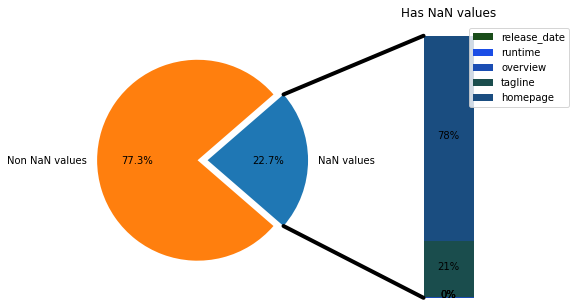

In [12]:
# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5.0625)) #5.0625
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = nan_in_percentages()
labels = ['NaN values', 'Non NaN values']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
ratios = sorted([val/sum(df_info.loc['null values'].values) for val in df_info.loc['null values'] if val != 0], reverse=False)
width = .2
colors = [[.1, .3, .1], [.1, .3, .9], [.1, .3, .7], [.1, .3, .3], [.1, .3, .5]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Has NaN values')
ax2.legend(([df_info.loc['null values'].sort_values(ascending=True).index[col] for col, val in enumerate(df_info.loc['null values'].sort_values(ascending=True)) if val != 0]))
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, bar_height), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, 0), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

#plt.savefig('testpiepig_pandas_900dpi.svg', dpi=900)
plt.show()

Det ses på grafen ovenfor, at det 77,3% af alle variabler i vores datasæt indeholder data, mens 22,7% ikke gør, men ud af de 22,7% er 78% af dem data der mangler på variablen "homepage". <br>
"homepage" variablen er sammentidigt en variabel vi ikke kan bruge til noget i forhold til det initierende problem, som er: Der ønskes film anbefalinger baseret på det givne datasæt. <br>
21% er variablen "tagline" der indeholder noget beskrivende om filmen handling - Denne variabel vil være oplagt at lave TF-IDF på, men da den indeholder så mange NaN værdier på man stærkt overveje, om variablen stadig bør anvendes. <br>
"realease_date", "runtime", "overview" udgør hver især mindre end 1% og derfor er der tale om få NaN værdier i disse variabler.

# Top 10 film

### Top 10 film baseret på den gennemsnitlige bedømmelse
Nu når alt data er samlet ét datasæt, er vi nu interesseret, at give nogle film anbefalinger ud fra det data vi er givet.
Dette kan lade sig gøre ved at se på variablen vote_average.

In [13]:
main_df[["title", "release_date", "vote_average", "vote_count"]].sort_values("vote_average", ascending=False).head(10)

,title,release_date,vote_average,vote_count
3519,Stiff Upper Lips,1998-06-12,10.0,1
4247,Me You and Five Bucks,2015-07-07,10.0,2
4045,"Dancer, Texas Pop. 81",1998-05-01,10.0,1
4662,Little Big Top,2006-01-01,10.0,1
3992,Sardaarji,2015-06-26,9.5,2
2386,One Man's Hero,1999-08-02,9.3,2
2970,There Goes My Baby,1994-09-02,8.5,2
1881,The Shawshank Redemption,1994-09-23,8.5,8205
2796,The Prisoner of Zenda,1937-09-03,8.4,11
3337,The Godfather,1972-03-14,8.4,5893


Det ses på tabellen ovenfor de 10 bedst bedømte film.<br>
Dette er ikke særlig given, da vi kan se nogle af de bedst rated film kun har 1 til 2 stemmer.

### Top 10 film baseret på det vægtede gennemsnit

Derfor vil vi lave en ny rating variabel der giver filmene en ny rating der også betragter antal stemmer den enkelte film har fået. Dette kan gøres ved hjælp af noget kaldt "Weighted Rating", der kan skrives som:<br>
Weighted Rating (WR)=(v/(v+m))R+(m/(v+m))C<br>
hvor:<br>
R = gennemsnits rating for filmen = "vote_average".<br>
v = antallet af stemmer for filmen = "vote_count".<br>
m = minimum antal stemmer krævet, for at være en "gyldig" film.<br>
C = gennemsnits rating for alle film.<br>

In [14]:
m = main_df['vote_count'].quantile(0.9)
C = main_df["vote_average"].mean()

main_df["WR"] = (main_df["vote_count"]/(main_df["vote_count"] + m)) * main_df["vote_average"] + (m/(main_df["vote_count"] + m)) * C

##### Det nye resultat
Der sorteres nu på de 10 bedste film baseret på vores nye variabel kaldet "WR" og det ses nu, at de film anbefalet baseret på WR er langt fra de 10 film vi fik anbefalet tidligere, dette skyldes at der vægtes på antallet af stemmer en film har modtaget.

In [15]:
main_df[['title', "release_date", 'vote_average', 'vote_count', 'WR']].sort_values("WR", ascending=False).head(10)

,title,release_date,vote_average,vote_count,WR
1881,The Shawshank Redemption,1994-09-23,8.5,8205,8.059258
662,Fight Club,1999-10-15,8.3,9413,7.939256
65,The Dark Knight,2008-07-16,8.2,12002,7.920020
3232,Pulp Fiction,1994-10-08,8.3,8428,7.904645
96,Inception,2010-07-14,8.1,13752,7.863239
3337,The Godfather,1972-03-14,8.4,5893,7.851236
95,Interstellar,2014-11-05,8.1,10867,7.809479
809,Forrest Gump,1994-07-06,8.2,7927,7.803188
329,The Lord of the Rings: The Return of the King,2003-12-01,8.1,8064,7.727243
1990,The Empire Strikes Back,1980-05-17,8.2,5879,7.697884


# Populære film

Vi kan nu give en komfortabel anbefaling af film baseret på deres bedømmelse, men nogle af de film er af ældre dato, hvilket leder os frem til spørgsmåle - hvad der er populært lige nu og her?

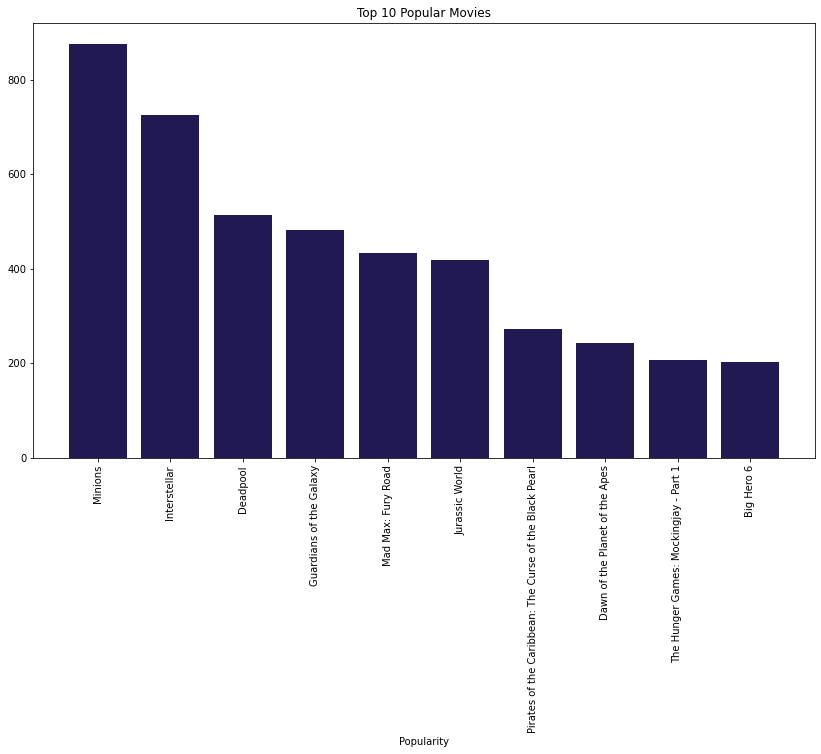

In [16]:
popular_movies = main_df.sort_values("popularity", ascending=False)

plt.figure(figsize=(14,8))

plt.bar(popular_movies['title'].head(10),popular_movies['popularity'].head(10), align='center', color='#211a52')
plt.xticks(rotation=90)
plt.xlabel("Popularity")
plt.title("Top 10 Popular Movies")
plt.show()

## Skaleret Score

Vi har nu de film der trender og de film, der har en høj rating. <br>
Hvis disse to variabler ønskes kombineret og vægtes ligeligt. <br>
Det vil resulterer i at WR og popularity vil vægte 50% hver især.

In [17]:
ss = MinMaxScaler().fit_transform(main_df[['popularity','WR']])

In [18]:
def scaled_score(x):
    return [(0.5 * ss[i][0]) + (0.5 * ss[i][-1]) for i in range(x)]

In [19]:
main_df['scaled_score'] = scaled_score(len(main_df.index))

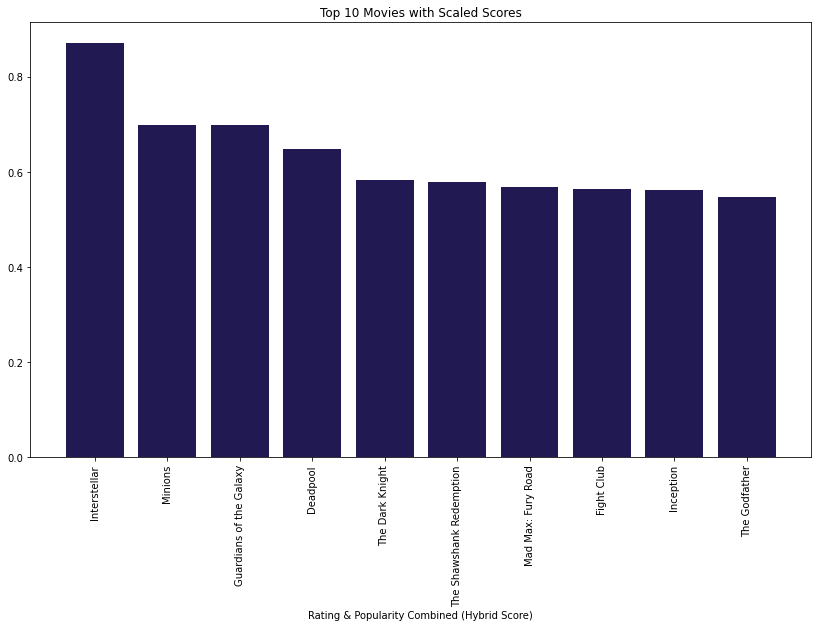

In [20]:
plt.figure(figsize=(14,8))
plt.bar(main_df.sort_values("scaled_score", ascending=False)['title'].head(10), 
         main_df.sort_values("scaled_score", ascending=False)['scaled_score'].head(10), 
         align='center', color='#211a52')
plt.xticks(rotation=90)
plt.xlabel("Rating & Popularity Combined (Hybrid Score)")
plt.title("Top 10 Movies with Scaled Scores")
plt.show()

### Data cleaning
Selvom vi har nogle løsninger i form af anbefalinger er løsningerne meget overfaldiske og generelle, da de ikke tager højde for den enkelte brugers preferencer. <br>
Dette vil vi tage højde for nu, ved at indtaste eksempelvis sin yndlingsfilm og ud fra den film finde film der minder om den indtastede film.<br>
Da mange af variablerne indeholder tekst værdier, er det nødvendigt at lave tekst om til noget vi kan regne på eksempelvis med tal værdier. Dette kan lade sig gøre ved hjælp af TD-IDF. <br>
Der eksisterer dog nogle variabler i datasættet der har værdier vi gerne vil rense, for unødvendige værdier og omskrive til nogle håndgribelige værdier, så vi kan udfører vores tekst analyse.

In [21]:
cleaned_df = main_df

In [22]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [23]:
# Get all the "names" from genre, cast, crew, keywords, productions_companies and spoken_languages.
# If there are no "names" return an empty list
def get_list(x):
    return [i['name'] for i in x] if isinstance(x, list) else []

In [24]:
features = ['cast', 'crew', 'keywords', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
for feature in features:
    cleaned_df[feature] = cleaned_df[feature].apply(literal_eval)

# Define new director, cast, genres and keywords features that are in a suitable form.
cleaned_df['director'] = cleaned_df['crew'].apply(get_director)

for feature in features:
    cleaned_df[feature] = cleaned_df[feature].apply(get_list)

#### Sådan ser de nye variabler ud efter noget rensning

In [25]:
cleaned_df[features].head()

,cast,crew,keywords,genres,production_companies,production_countries,spoken_languages
0,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]"
1,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English]
2,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[spy, based on novel, secret agent, sequel, mi...","[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]"
3,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],[English]
4,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...","[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]",[Walt Disney Pictures],[United States of America],[English]


# Grafisk oversigt
Her gives et generelt overblik over de forskellige værdier i datasættet.

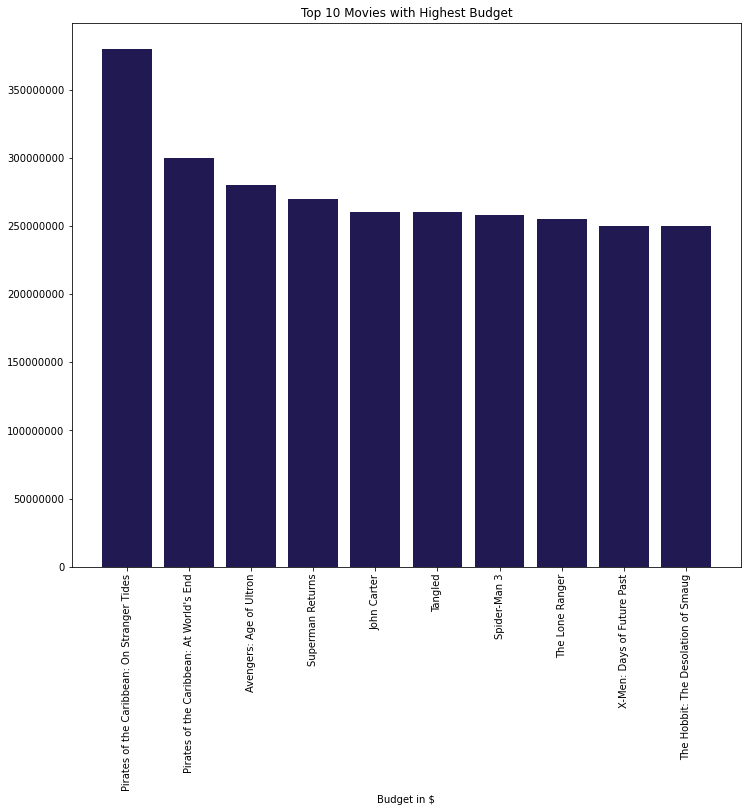

In [26]:
plt.figure(figsize=(12,10))
plt.bar(main_df.sort_values("budget", ascending=False)['title'].head(10), 
        main_df.sort_values("budget", ascending=False)['budget'].head(10), 
        align='center', color='#211a52')
plt.xlabel("Budget in $")
plt.ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=90)
plt.title("Top 10 Movies with Highest Budget")
plt.show()

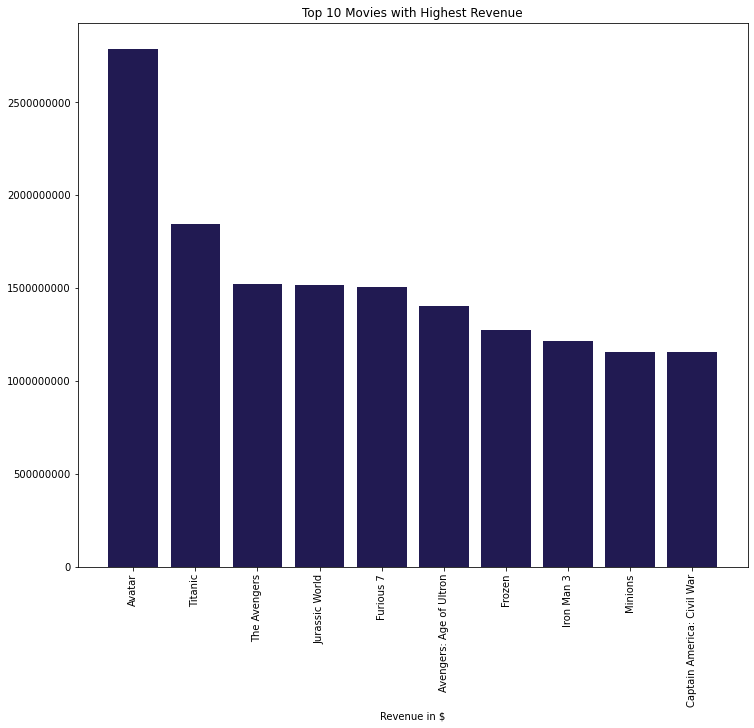

In [27]:
plt.figure(figsize=(12,10))
plt.bar(main_df.sort_values("revenue", ascending=False)['title'].head(10), 
         main_df.sort_values("revenue", ascending=False)['revenue'].head(10), 
         align='center', color='#211a52')
#plt.gca().invert_yaxis()
plt.xlabel("Revenue in $")
plt.xticks(rotation=90)
plt.ticklabel_format(axis='y', style='plain')
#plt.xaxis.get_offset_text().set_visible(False)
plt.title("Top 10 Movies with Highest Revenue")
plt.show()

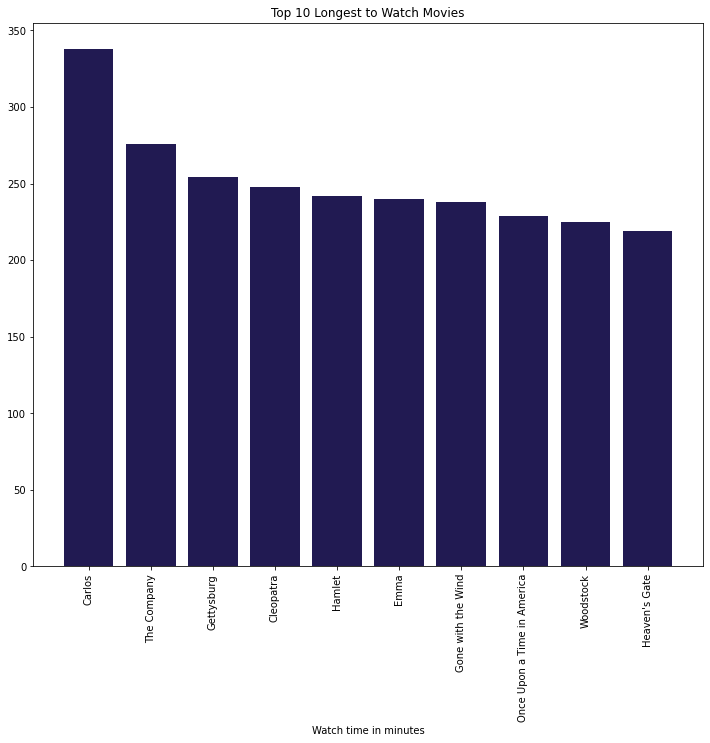

In [28]:
plt.figure(figsize=(12,10))
plt.bar(main_df.sort_values("runtime", ascending=False)['title'].head(10), 
         main_df.sort_values("runtime", ascending=False)['runtime'].head(10), 
         align='center', color='#211a52')
#plt.gca().invert_yaxis()
plt.xlabel("Watch time in minutes")
plt.xticks(rotation=90)
plt.ticklabel_format(axis='y', style='plain')
#plt.xaxis.get_offset_text().set_visible(False)
plt.title("Top 10 Longest to Watch Movies")
plt.show()

In [29]:
def vertical_bar_plot(data, title, len_return_val):
    plt.subplots(figsize=(12,10))
    
    data_list = []
    for i in data:
        if isinstance(i, str):
            if i != '':
                data_list.append(i)
        else:
            data_list.extend(i)

    ax = pd.Series(data_list).value_counts()[:len_return_val].sort_values(ascending=False).plot.bar(width=0.9,color='#211a52')
    
    #for i, v in enumerate(pd.Series(data_list).value_counts()[:len_return_val].sort_values(ascending=False).values): 
        #ax.text(.8, i, v, fontsize=12, color='white', weight='bold')
    
    plt.title(title)
    plt.show()

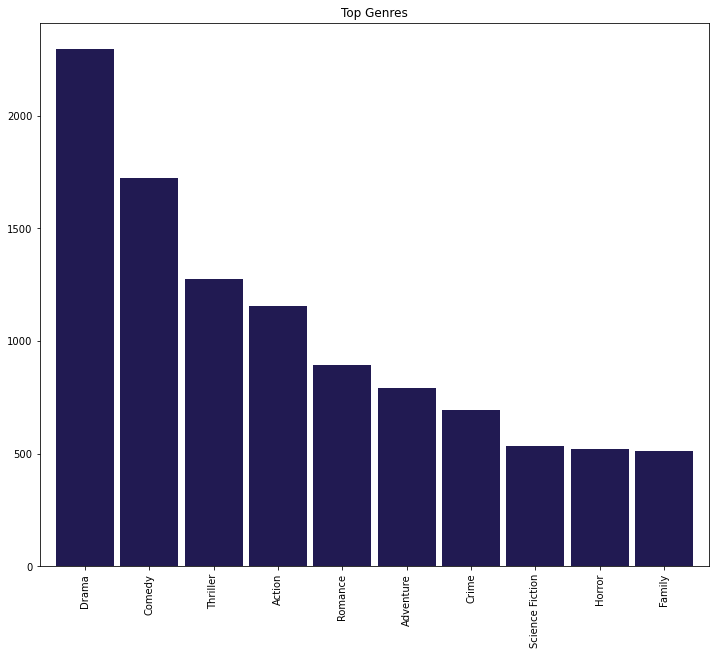

In [30]:
vertical_bar_plot(cleaned_df['genres'], 'Top Genres', 10)

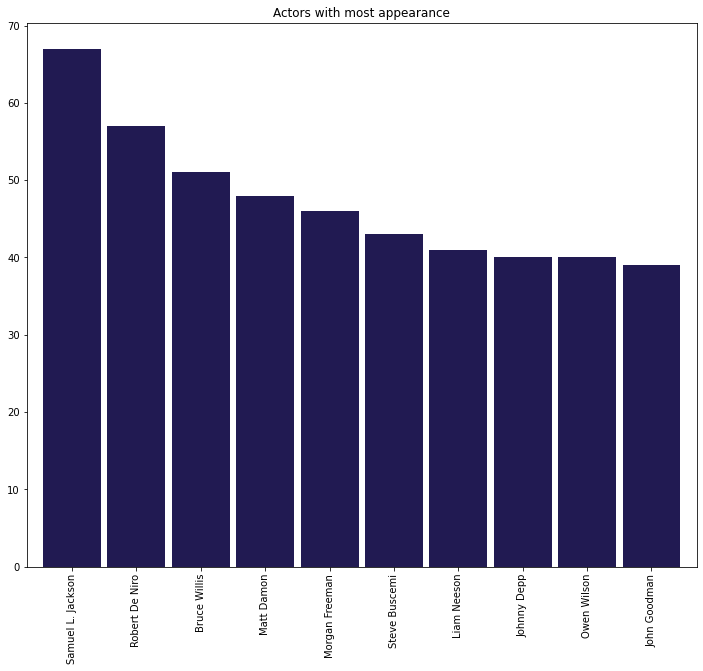

In [31]:
vertical_bar_plot(cleaned_df['cast'], 'Actors with most appearance', 10)

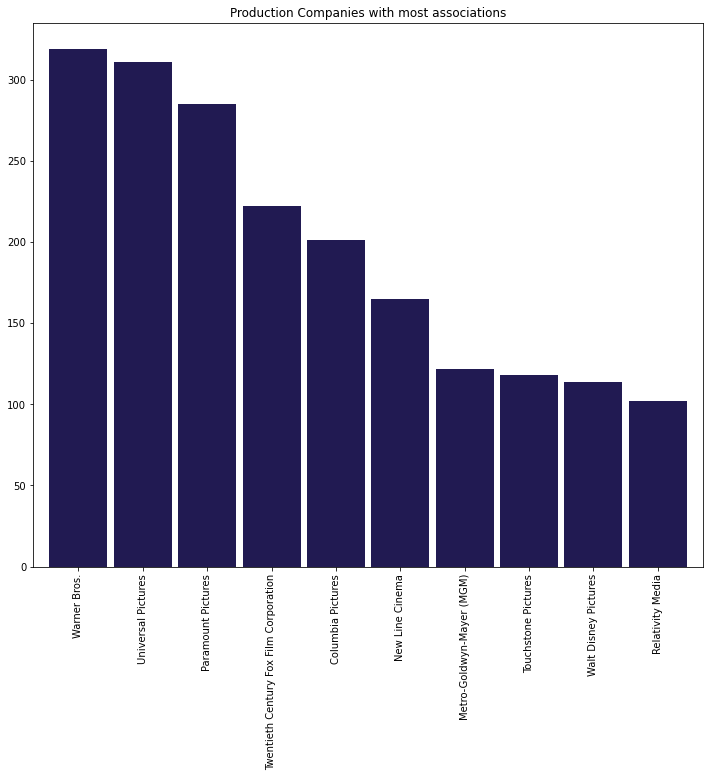

In [32]:
vertical_bar_plot(cleaned_df['production_companies'], 'Production Companies with most associations', 10)

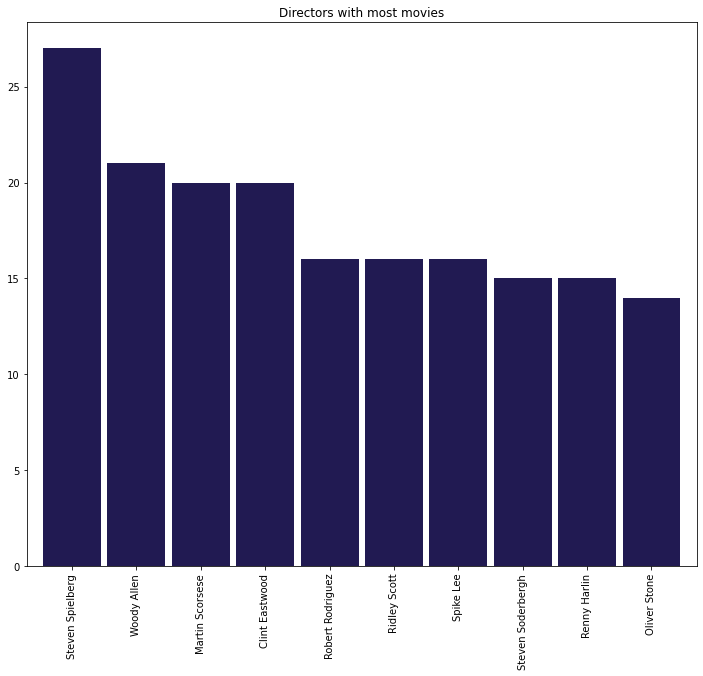

In [33]:
vertical_bar_plot(cleaned_df['director'].fillna(''), 'Directors with most movies', 10)

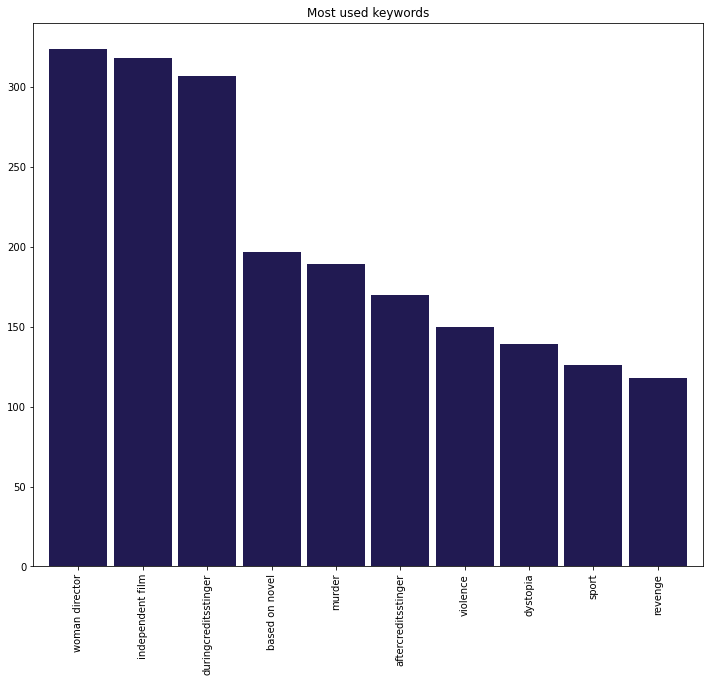

In [34]:
vertical_bar_plot(cleaned_df['keywords'], 'Most used keywords', 10)

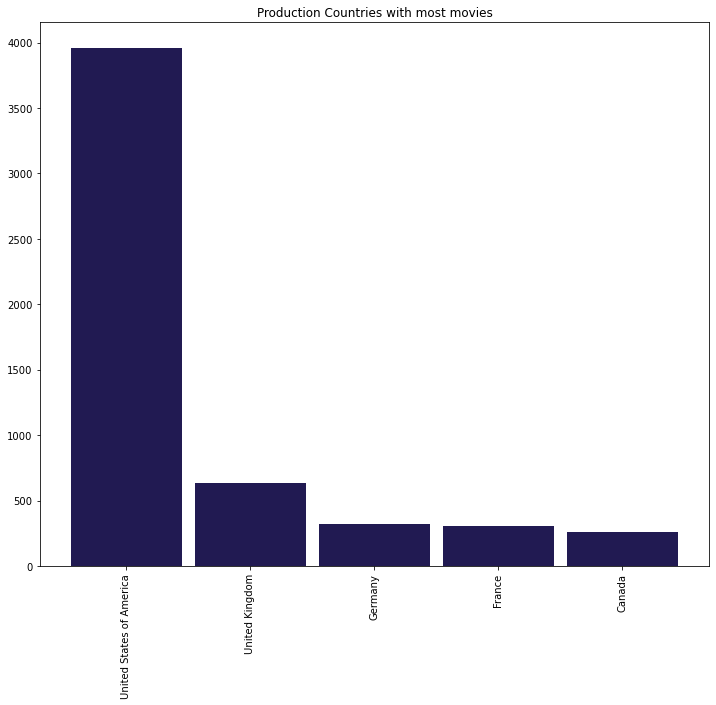

In [35]:
vertical_bar_plot(cleaned_df['production_countries'], 'Production Countries with most movies', 5)

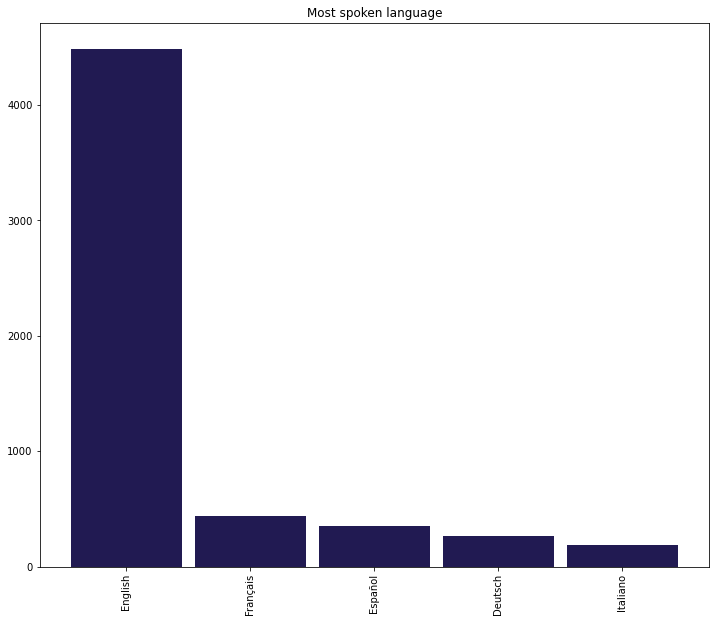

In [36]:
vertical_bar_plot(cleaned_df['spoken_languages'], 'Most spoken language', 5)

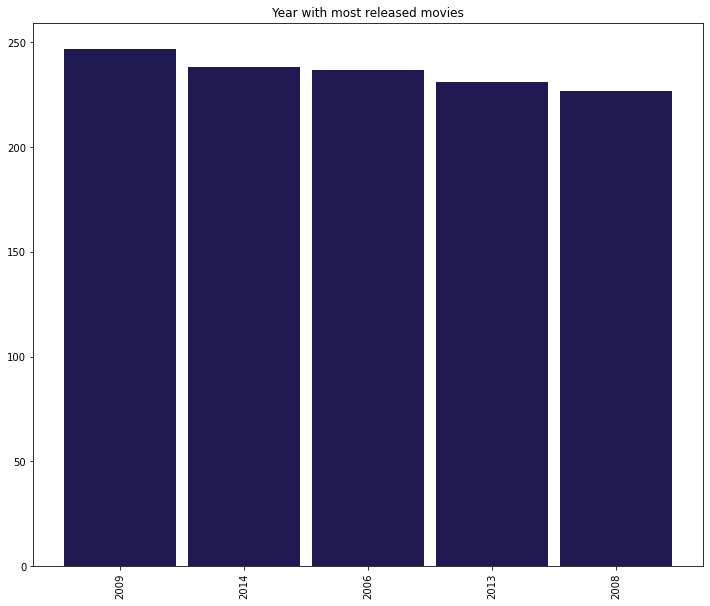

In [37]:
year_list = []
for date in cleaned_df['release_date'].fillna('').str.split('-'):
    year_list.append(date[0])
vertical_bar_plot(year_list, 'Year with most released movies', 5)

In [38]:
cleaned_df.drop(columns=['homepage', 'original_language', 'tagline', 'original_title', 'runtime', 'spoken_languages', 'vote_average', 'vote_count', 'status', 'production_countries', 'crew', 'budget', 'revenue', 'release_date', 'genres', 'production_companies'], inplace=True)

In [39]:
cleaned_df.columns

Index(['id', 'keywords', 'overview', 'popularity', 'title', 'cast', 'WR',
       'scaled_score', 'director'],
      dtype='object')

# TF-IDF og Content Based Filtering
Det er nu tid til at påbegynde den del, der anbefaler eksempelvis 10 film baseret på sin yndlingsfilm eller en hvilken som helst anden given film.

In [40]:
# It is required to install stopwords, before running this code. This is done by:
# >conda install -c anaconda nltk
# >python
# >>>import nltk
# >>>nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','', "he's","who's", "it's", 'hes', 'shes', 'whos', '--', '–')
print(stop_words)

{"she's", 'any', 'by', 'through', "needn't", 'after', 'that', 'up', 'all', "don't", 'been', "hadn't", "wouldn't", 'this', 'isn', 'she', 'the', '.', 'in', ':', ',', 'ours', "should've", 'couldn', 'above', 'won', 'now', 've', 'himself', 'being', 'when', 'am', 'haven', ' ', 'there', 'our', "you'd", "hasn't", 'can', 'on', 'myself', 'under', 'm', '?', 'h', 'are', 'shouldn', 'did', 'than', 'had', 'from', 'i', 'hasn', 'aren', "didn't", "that'll", '(', 'who', 'yourselves', 'while', "weren't", 's', "isn't", 'themselves', 'into', 'out', 'hers', 'at', 'wouldn', "mustn't", ')', 'll', 'because', 'other', 'such', 'those', 'where', 'same', "you've", 'him', 'we', 'not', 'again', 'too', 'they', 'own', 'it', "couldn't", 'needn', 'what', 'most', '$', 'should', 'you', 'against', 'wasn', 'itself', 'is', 'and', 'with', 'no', 'for', 'theirs', 'but', '+', 'yourself', 'only', "haven't", "shan't", 'an', 'until', 'having', 'mightn', 'w', "it's", 'how', '!', "aren't", "you'll", 'has', 'does', 'ain', 'them', 'don'

In [41]:
#Replace NaN with an empty string
cleaned_df['overview'] = cleaned_df['overview'].fillna('') # Or drop NA?

#### overview_cleaning funkltionen
Denne funktion rengører vores film beskrivelse ved hjælp af stopwords og en ekstra filtrering i form af special tegn og andet.
<br>
<br>
OBS - Det er vigtigt at påpege, at tf-idf ikke kan genkende synonymer eller forstår stavefejl eller sætningen i sig selv, men kigger kun på ordet eller tekst strengen i sig selv. Dette vil resulterer i at eksempelvis at peter og peters ikke er det samme, ligesom at peters og peter's heller ikke har samme betydning.
Da vores liste af unikke ord efter filtrering af stopwords og alt andet indeholder stadig 24067 ord og der er med en statistisk sikkerhed ord der burde være "ens" men ikke er, da ordet har en apostrof eller andet der differentierer den fra det originale ord.

In [42]:
def overview_cleaning(x):
    x = x.lower().strip('[]').replace('"','').replace('?','').replace('.','').replace(',','').replace('(','').replace(')','').replace("'",'').replace('"','').replace(':','').replace('“','').split()
    return [w for w in x if w not in stop_words]

In [43]:
cleaned_df['overview_cleaned'] = cleaned_df['overview'].apply(lambda x: overview_cleaning(x))

#### Unikke ord
Her oprettes variablen der indheholder alle unikke ord og vil blive anvendt flere gange senere.

In [54]:
overview = cleaned_df['overview_cleaned']
bigrams = []
for sentence in overview:
    bigrams += ([w + ' ' + sentence[i+1] for i, w in enumerate(sentence) if i < len(sentence)-1])
    if "life" in sentence and "latest" in sentence:
        print(sentence)
    
#print(bigrams)
    #if bigrams[-1] == "secretly fabulous":
    #    print(sentence)
#print(bigrams.index("secretly fabulous"), bigrams[11263])
#print(overview[:30])
bigrams = list(set(bigrams))
#print(len(bigrams))

['danny', 'obsessed', 'fictional', 'movie', 'character', 'action', 'hero', 'jack', 'slater', 'magical', 'ticket', 'transports', 'jacks', 'latest', 'adventure', 'danny', 'finds', 'world', 'movie', 'magic', 'reality', 'collide', 'danny', 'save', 'life', 'hero', 'new', 'friend']
['seasoned', 'team', 'bank', 'robbers', 'including', 'gordon', 'jennings', 'idris', 'elba', 'john', 'rahway', 'paul', 'walker', 'aj', 'hayden', 'christensen', 'brothers', 'jake', 'michael', 'ealy', 'jesse', 'attica', 'chris', 'brown', 'successfully', 'complete', 'latest', 'heist', 'lead', 'life', 'luxury', 'planning', 'next', 'job', 'ghost', 'tip', 'ti', 'harris', 'former', 'member', 'team', 'released', 'prison', 'convinces', 'group', 'strike', 'armored', 'car', 'carrying', '$20', 'million', 'takers', 'carefully', 'plot', 'strategy', 'draw', 'nearer', 'exacting', 'grand', 'heist', 'reckless', 'police', 'officer', 'matt', 'dillon', 'inches', 'closer', 'apprehending', 'criminals']
['young', 'shakespeare', 'forced', 

### TF
Her beregnes Term Frequency, funktionen tf_calculator returnerer en dictionary med de ord der er anvendt for en vilkårlig film som key og antal gange ét ord indgår i beskrivelsen for den vilkårlige film og dette divideres med det totale antal af ord i beskrivelsen og dette er vores value for ordet.

In [50]:
def new_tf(x):
    bow_dict = dict.fromkeys([w + ' ' + x[i+1] for i, w in enumerate(x) if i < len(x)-1], 0)
    for i in range(len(x)-1):
        bow_dict[x[i] + ' ' + x[i+1]] += 1
    for key in bow_dict:
        bow_dict[key] = bow_dict[key] / x.count(key.split()[0])
    return(bow_dict)

In [51]:
tf = cleaned_df['overview_cleaned'].apply(lambda x: new_tf(x))

In [178]:
#def tf_calculator(x):
#    tf_dict = dict.fromkeys(x, 0)
#
#    for w in x:
#        tf_dict[w] += 1
#    for word in tf_dict:
#        tf_dict[word] = tf_dict[word] / len(x)
#    return tf_dict

In [179]:
#tf = cleaned_df['overview_cleaned'].apply(lambda x: tf_calculator(x))

### IDF
Her beregnes Inverse Document Frequency. funktionen idf_calculator returnerer en dictionary med unikke ord som keys og som value er det antal af film divideret med antallet af gange ordet x forekommer - Hvis ordet x forekommer i alle film vil værdien være 4803, da vi har i alt 4803 film og dette er også tilfældet selvom ordet x forekommer mere end 1 gang i flere film, da dette ikke tages højde for.

In [52]:
import time

start_time = time.time()
def idf_calculator():
    idf_dict = dict.fromkeys(bigrams, 0)
    n = len(cleaned_df)
    for i, word in enumerate(bigrams):
        if i <= 100:
            for movie in cleaned_df['overview_cleaned']:
                movie = ([w + ' ' + movie[i+1] for i, w in enumerate(movie) if i < len(movie)-1])
                if word in movie:
                    idf_dict[word] += 1
            
    for word in idf_dict:
        print(word)
        print(idf_dict[word])
        idf_dict[word] = math.log10(n/idf_dict[word])
    return idf_dict

In [53]:
idf = idf_calculator()
print("Varighed: ", time.time() - start_time)

guitarist soon
1
replace rotting
1
day finally
3
la vega
2
army shrewd
1
planet earth
2
potter steals
1
james pumphrey
1
who’s mother
1
detectives dispatched
1
regain former
1
crowds brutally
1
steadily draws
1
salesman particular
1
tour disparate
1
center 1974
1
stars betty
1
missing person;
1
director bill
1
freeway keeping
1
drug-fueled paranoia
1
expertise expendables’
1
belong questioning
1
big noise
1
domestic bliss
1
couple hears
1
life purchases
1
atlantic ocean
2
home jones
1
find assassins
1
sets work
2
lost crab
1
nothing sheeni
1
trapped situation
1
late mother
1
unpublished novelist
1
david israel
1
resides home
1
son eventually
1
mission requires
1
coach harold
1
george want
1
sets magic
1
journalist poet
1
night theyll
1
grown-up romance
1
drag-race win
1
us bases
1
connects dead
1
small west
1
nightmare la
1
stop red
1
threats one
1
nuclear missiles
1
carter replacement
1
pit worlds
1
hear virginal
1
tiger doesnt
1
competition drew
1
schooler abandoned
1
kyle laid
1
dem

ZeroDivisionError: division by zero

### TF-IDF
funktionen returnerer en liste af dictionaries, hvor værdierne i disse dictionaries ganges sammen med den tilsvarende idf værdi - altså idf værdien for ordet "peter" ganges med tf værdien for samme ord, altså "peter".

In [ ]:
def tfidf_calculator(tf, idf):
    for tf_word in tf:
        if tf_word in idf:
            tf[tf_word] = tf[tf_word] * idf[tf_word]
    return tf

In [ ]:
tfidf = tf.apply(lambda x: tfidf_calculator(x, idf))

### Matricen
Funktionen tfidf_matrix returnerer en matrice, der går igennem alle unikke ord og giver tilføjer værdien 0, hvis ordet ikke eksisterer i, beskrivelsen af en given film ellers tilføjes TF-IDF værdien, hvis ordet eksisterer i beskrivelsen til filmen.  

In [ ]:
def tfidf_matrix(tfidf_dict):
    matrix = []
    for unique_word in unique_words:
        if unique_word in tfidf_dict:
            matrix.append(tfidf_dict[unique_word])
        else:
             matrix.append(0)
    return matrix

In [ ]:
cleaned_df['tfidf_matrix'] = tfidf.apply(lambda x: tfidf_matrix(x))

## Cosine Simularity
Der er umiddelbart to metoder vi kan anvende, da vi har lister af værdier, den metode, hvor numpy anvendes, siges at være den "hurtigeste" i form af runtime.

In [ ]:
# Function that takes in movie title as input.
def get_recommendations(title):
    movie_list = []
    original_movie_tfidf = list(cleaned_df.loc[cleaned_df['title'] == title]['tfidf_matrix'])
    for i in range(len(cleaned_df) -1):
        movie_list.append(1 - distance.cosine(original_movie_tfidf, cleaned_df['tfidf_matrix'][i]))
    recommended_movies = pd.Series(movie_list).nlargest(11)
    for i in recommended_movies.index[1:]:
        print(cleaned_df.iloc[i]['title'])
    
get_recommendations('The Dark Knight Rises')

### Eksekvering af TF-IDF ved anvendelse af sklearn pakken
Det ses tydeligt at performance er langt bedre, da eksekveringstiden er få sekunder.

In [54]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
#tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
#tfidf_matrix = tfidf.fit_transform(cleaned_df['overview'])

#Output the shape of tfidf_matrix
#tfidf_matrix.shape

#print(tfidf_matrix)